# Proyecto 2 - Emanuel Caneva :  Análisis de mercado inmobiliario

El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

El trabajo se organiza en tres partes:

## PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

    1.Detección y eliminación de Outliers

    2.Encoding

    3.Imputación de valores faltantes

    4.Escalado de datos

    5.Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

## PARTE B - Modelos Avanzados

Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

## PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

 **DESAFÍO OPCIONAL**

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?



## PARTE A - Transformación de Datos

*Importo las librerías necesarias*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

*Cargo el dataset y exploro*

In [2]:
dataset_properati = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

dataset_properati.shape

(146660, 19)

In [4]:
dataset_properati.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,136735.000000,136701.000000,146660.000000,146660.000000,140703.000000,126133.000000,125046.000000,1.466600e+05
mean,-34.604896,-58.465304,3.079817,1.983240,1.599994,216.872888,112.818011,2.412211e+05
std,0.468428,0.486190,1.416352,1.151304,0.889324,2037.606649,916.857584,3.185195e+05
min,-35.318457,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,-34.627667,-58.504012,2.000000,1.000000,1.000000,52.000000,47.000000,1.110000e+05
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,-34.574600,-58.407586,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,85.051129,-57.805832,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


In [5]:
dataset_properati.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


*Filtro el dataset*

In [6]:
#En este punto filtro el dataset tal como en el Proyecto 1 para luego también comparar con los resultados obtenidos 
#anteriormente,toma Departamento, Casa y PH para Capital y que la superficie cubierta sea menor o igual a la total
dataset_properati=dataset_properati[(dataset_properati.property_type.isin(['Departamento','Casa','PH'])) & (dataset_properati.l2 == 'Capital Federal') & (dataset_properati['surface_covered']<=dataset_properati['surface_total'])]

In [7]:
dataset_properati.shape

(81291, 19)

*Elimino las columnas que no voy a usar para predecir*

In [8]:
#De acuerdo a lo reslizado en el Proyecto 1 descarto las columnas que no voy a usar
dataset_properati = dataset_properati.drop(['lat','lon','start_date','end_date','l1','created_on','currency','title','description','operation_type'],axis = 'columns')
dataset_properati.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH


**A.1 - Detección y eliminación de Outliers**

Si bien por el Proyecto 1 ya tengo conocimiento que el dataset posee varios outliers, voy a estudiar la distribución de cada variable antes de aplicar esta técnica, considero apropiada por lo expresado anteriormente y considero que puede mejorar el desempeño del modelo

*Defino una funcion para eliminar los outliers a través del Rango Intercuartílico, la misma recibe como argumento un dataset
y la variable a la cual se le eliminaran los outliers, devuelve un filtro con los datos a eliminar*

In [9]:
def eliminar_outliers(dataset,var):
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

*Estudio la distribución de las variables para detectar outliers* 

*Variable Superficie Total*

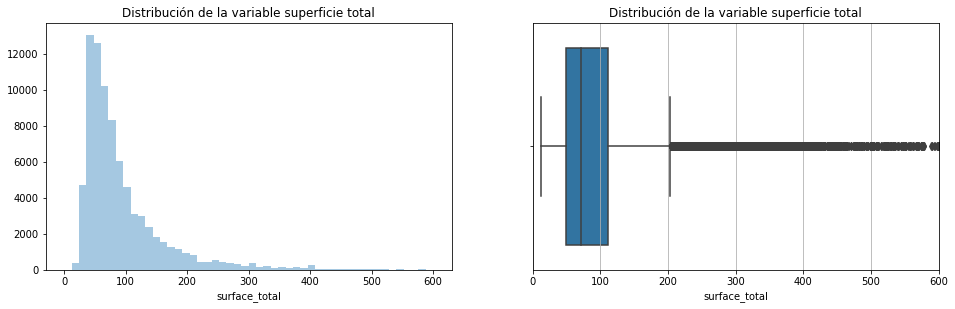

In [10]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_properati['surface_total'],bins=50,kde=False,hist=True,hist_kws={"range": [0,600]})
plt.title('Distribución de la variable superficie total')

plt.subplot(2,2,2)
sns.boxplot(dataset_properati['surface_total'])
plt.grid(axis = 'x')      
plt.title('Distribución de la variable superficie total')
plt.xlim(0,600)

plt.show()

In [11]:
#llamo a la función definida para eliminar ouliers de Superficie total y cuento la cantidad que se eliminarán
mascara_outliers_sup_total=eliminar_outliers(dataset_properati,'surface_total')
mascara_outliers_sup_total.sum()

6218

In [12]:
#Filtro el dataset sacando los outliers encontrados en el punto anterior
dataset_properati=dataset_properati[~mascara_outliers_sup_total]
dataset_properati.shape

(75073, 9)

*Variable Superficie Cubierta*

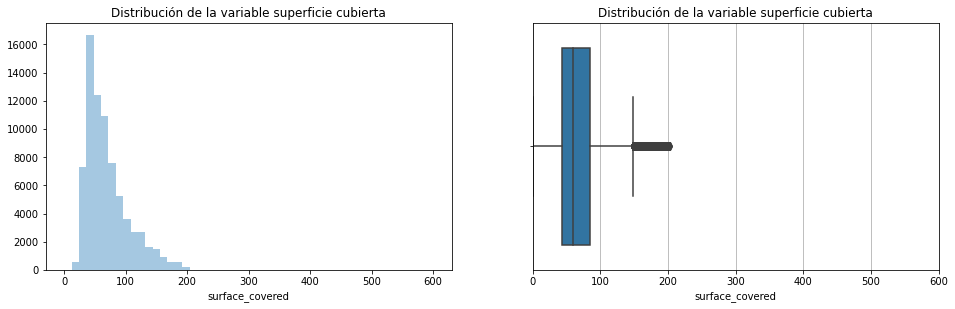

In [13]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_properati['surface_covered'],bins=50,kde=False,hist=True,hist_kws={"range": [0,600]})
plt.title('Distribución de la variable superficie cubierta')

plt.subplot(2,2,2)
sns.boxplot(dataset_properati['surface_covered'])
plt.grid(axis = 'x')      
plt.title('Distribución de la variable superficie cubierta')
plt.xlim(0,600)

plt.show()

In [14]:
#llamo a la función definida para eliminar ouliers de Superficie cubierta y cuento la cantidad que se eliminarán
mascara_outliers_sup_cubierta=eliminar_outliers(dataset_properati,'surface_covered')
mascara_outliers_sup_cubierta.sum()

3165

In [15]:
#Filtro el dataset sacando los outliers encontrados en el punto anterior
dataset_properati=dataset_properati[~mascara_outliers_sup_cubierta]
dataset_properati.shape

(71908, 9)

*Variable rooms*

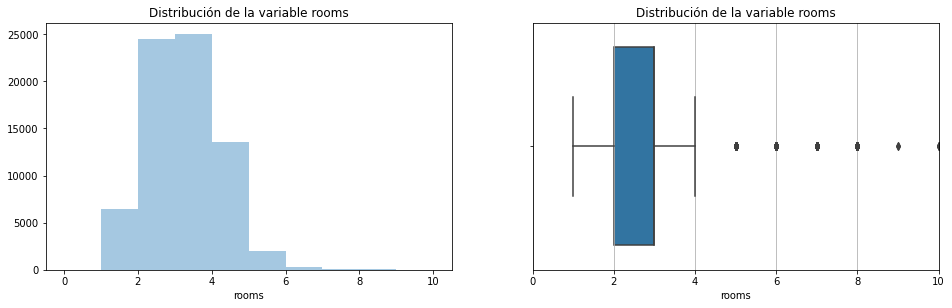

In [16]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_properati['rooms'],bins=10,kde=False,hist=True,hist_kws={"range": [0,10]})
plt.title('Distribución de la variable rooms')

plt.subplot(2,2,2)
sns.boxplot(dataset_properati['rooms'])
plt.grid(axis = 'x')      
plt.title('Distribución de la variable rooms')
plt.xlim(0,10)

plt.show()

In [17]:
#llamo a la función definida para eliminar ouliers de rooms y cuento la cantidad que se eliminarán
mascara_outliers_rooms=eliminar_outliers(dataset_properati,'rooms')
mascara_outliers_rooms.sum()

2433

In [18]:
#Filtro el dataset sacando los outliers encontrados en el punto anterior
dataset_properati=dataset_properati[~mascara_outliers_rooms]
dataset_properati.shape

(69475, 9)

*Variable bedrooms*

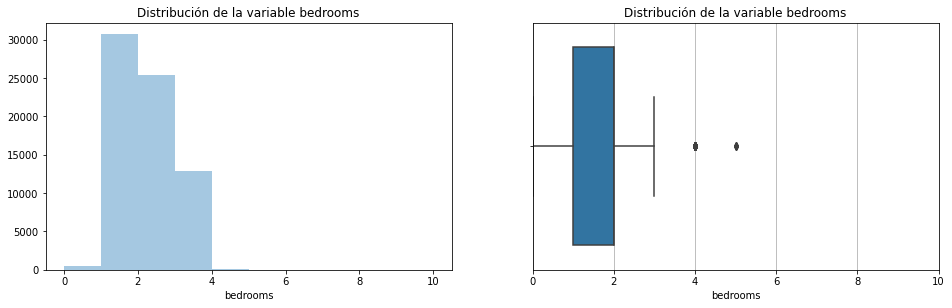

In [19]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_properati['bedrooms'],bins=10,kde=False,hist=True,hist_kws={"range": [0,10]})
plt.title('Distribución de la variable bedrooms')

plt.subplot(2,2,2)
sns.boxplot(dataset_properati['bedrooms'])
plt.grid(axis = 'x')      
plt.title('Distribución de la variable bedrooms')
plt.xlim(0,10)

plt.show()

In [20]:
#llamo a la función definida para eliminar ouliers de rooms y cuento la cantidad que se eliminarán
mascara_outliers_bedrooms=eliminar_outliers(dataset_properati,'bedrooms')
mascara_outliers_bedrooms.sum()

115

In [21]:
#Filtro el dataset sacando los outliers encontrados en el punto anterior
dataset_properati=dataset_properati[~mascara_outliers_bedrooms]
dataset_properati.shape

(69360, 9)

*Variable bathrooms*

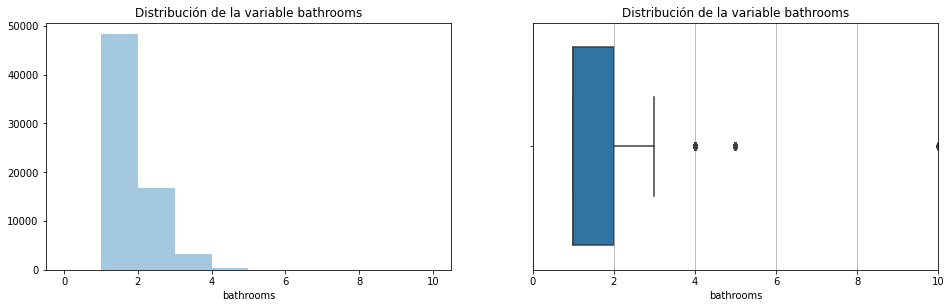

In [22]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_properati['bathrooms'],bins=10,kde=False,hist=True,hist_kws={"range": [0,10]})
plt.title('Distribución de la variable bathrooms')

plt.subplot(2,2,2)
sns.boxplot(dataset_properati['bathrooms'])
plt.grid(axis = 'x')      
plt.title('Distribución de la variable bathrooms')
plt.xlim(0,10)

plt.show()

In [23]:
#llamo a la función definida para eliminar ouliers de rooms y cuento la cantidad que se eliminarán
mascara_outliers_bathrooms=eliminar_outliers(dataset_properati,'bathrooms')
mascara_outliers_bathrooms.sum()

0

*Variable Precio*

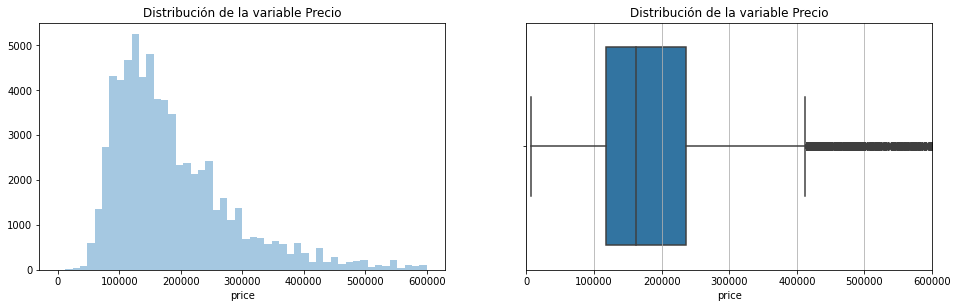

In [25]:
plt.figure(figsize = (16,10))

plt.subplot(2,2,1)
sns.distplot(dataset_properati['price'],bins=50,kde=False,hist=True,hist_kws={"range": [0,600000]})
plt.title('Distribución de la variable Precio')

plt.subplot(2,2,2)
sns.boxplot(dataset_properati['price'])
plt.grid(axis = 'x')      
plt.title('Distribución de la variable Precio')
plt.xlim(0,600000)

plt.show()

In [26]:
mascara_outliers_precio=eliminar_outliers(dataset_properati,'price')
mascara_outliers_precio.sum()

3679

In [27]:
#Filtro el dataset sacando los outliers encontrados en el punto anterior
dataset_properati=dataset_properati[~mascara_outliers_precio]
dataset_properati.shape

(65681, 9)

**A.2 - Imputación de valores faltantes**

Aplico esta técnica para no descartar las filas que tengan valores faltantes, ya que las mismas aportan información al modelo

In [28]:
#Busco los valores faltantes por columnas
print(dataset_properati.isna().sum())

l2                   0
l3                   0
rooms                0
bedrooms             0
bathrooms          664
surface_total        0
surface_covered      0
price                0
property_type        0
dtype: int64


In [29]:
#Aplico un simple Imputer para sustituir valores nulos por la mediana, ya que la distribución según lo visto en el A1 no son
# del todo normales.

imp = SimpleImputer(missing_values=np.nan, strategy='median')

#Ejecuto la sustitución en cada uno de las columnas con valores faltantes

dataset_properati.bathrooms = imp.fit_transform(dataset_properati.bathrooms.values.reshape(-1, 1))

In [30]:
#Compruebo que no haya valores faltantes en alguna columna
print(dataset_properati.isna().sum())

l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64


**A.3 - Escalado de datos**

Aplico esta técnica porque las variables tienen escalas muy diferentes, como ser la cantidad de habitaciones baños y piezas difieren mucho de la superficie total por ejemplo, llevar todas las variables a una misma unidad debería ayudar a mejorar el rendimiento del modelo.

In [31]:
#Tomo el dataset anterior y lo asignno a uno donde aplicare el escalado
data_scaler=dataset_properati.copy()

scaler = StandardScaler()
data_scaler.rooms = scaler.fit_transform(data_scaler.rooms.values.reshape(-1, 1))
data_scaler.bedrooms = scaler.fit_transform(data_scaler.bedrooms.values.reshape(-1, 1))
data_scaler.bathrooms = scaler.fit_transform(data_scaler.bathrooms.values.reshape(-1, 1))
data_scaler.surface_total = scaler.fit_transform(data_scaler.surface_total.values.reshape(-1, 1))
data_scaler.surface_covered = scaler.fit_transform(data_scaler.surface_covered.values.reshape(-1, 1))
data_scaler.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
1,Capital Federal,Boedo,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,PH
2,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,PH
3,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,PH
5,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,-0.416126,-0.178409,150000.0,PH
6,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,0.041585,0.395819,159500.0,PH


**A.4 - Transformación de atributos categóricos en información**

Aplico esta técnica para poder usar los atriburos categóricos en las predicciones.

In [32]:
#Hago una copia del dataset de la sección anterior
data_encoder=data_scaler.copy()

*Creo una función para agregar a un dataframe todas las columnas generadas con OneHotEncoder*

In [33]:
#Parametros
#data: dataframe al cual se le agregarán las columnas
#Columna: el nombre de la columna sobre el cual se aplico el OHE
#ohe_labeled: las columnas generadas con el OHE
#class_labels: las clases de etiquetas de la columna a la cual se le aplico el OHE

def pdAsigOhe(data, columna, ohe_labeled, class_labels):
    para_asig = {}
    for i, label in enumerate(class_labels):
        para_asig[columna+'_'+label] = ohe_labeled[:,i]
    data = data.assign(**para_asig)
    return data

*Transformación de la varible property_type*

In [34]:
#Como OneHotEncoder solo funciona con datos categóricos numéricos, uso LabelEncoder para codificar las etiquetas de 
#cadena con números

#Aplico LabelEncoder a la varible property_type 
la_property_type = LabelEncoder()
property_type_transfor = la_property_type.fit_transform(data_encoder.property_type)
property_type_transfor_classes = la_property_type.classes_

In [35]:
#Aplico OneHotEncoder a la varible property_type
ohe_property_type = OneHotEncoder(sparse=False)
property_type_ohe = ohe_property_type.fit_transform(property_type_transfor.reshape(-1,1))
property_type_ohe.shape

(65681, 3)

In [36]:
#Invoco a la función pdAsigOhe para agregar las columnas al DataFrame
data_encoder = pdAsigOhe(data_encoder, 'property_type',property_type_ohe, property_type_transfor_classes)

In [37]:
data_encoder.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,property_type_Casa,property_type_Departamento,property_type_PH
1,Capital Federal,Boedo,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,PH,0.0,0.0,1.0
2,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,PH,0.0,0.0,1.0
3,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,PH,0.0,0.0,1.0
5,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,-0.416126,-0.178409,150000.0,PH,0.0,0.0,1.0
6,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,0.041585,0.395819,159500.0,PH,0.0,0.0,1.0


*Transformación de la varible l3*

In [38]:
#Aplico la tranformación a la varible l3 usando Label Encoder, en este punto si bien sabemos que l3 no es una variable ordinal
#uso este método ya que usando OneHotEncoder generaría gran cantidad de variables, de hecho lo hice previamente y el modelo,
# al menos en el punto A no generaba mejores resultados que usando esta opción

la_l3 = LabelEncoder()
l3_transfor = la_l3.fit_transform(data_encoder.l3)
data_encoder=data_encoder.assign(barrios_enc=l3_transfor)

In [39]:
#Elimino las columnas a las cuales les aplique transformación y el resto de las columnas que no voy a utilizar
data_encoder = data_encoder.drop(['l3','l2','property_type'],axis = 'columns')
data_encoder.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,barrios_enc
1,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,0.0,0.0,1.0,8
2,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,0.0,0.0,1.0,26
3,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,0.0,0.0,1.0,26
5,-0.689694,-0.925024,-0.540584,-0.416126,-0.178409,150000.0,0.0,0.0,1.0,44
6,-0.689694,-0.925024,-0.540584,0.041585,0.395819,159500.0,0.0,0.0,1.0,44


**A.5 - Entrenamiento del modelo y evaluación de desempeño**

In [40]:
#Hago una copia del modelo del punto anterior
data_modelos=data_encoder.copy()

X = data_modelos.drop("price", axis=1)
y = data_modelos.price
X.shape

(65681, 9)

In [41]:
# hago un Train/Test split de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45976, 9) (45976,) (19705, 9) (19705,)


*Defino los modelos de Arbol de desición y vecionos mas cercanos y buscamos los parámetros más optimos*

In [42]:
tree_regressor = DecisionTreeRegressor()
knn_regressor = KNeighborsRegressor()

tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

Optimización para vecinos mas cercanos

In [43]:
# Defino las listas vacias para los valores de mse deseados

lista_rmse_train = []
lista_rmse_test = []

# Defino la lista de valores de k que voy a explorar
k_vecinos = np.arange(1,15)

# Genero en loop sobre los distintos valores de k 
for k in k_vecinos:
     
    # Definir el modelo con el valor de vecinos deseado
    reg = KNeighborsRegressor(n_neighbors=k)
    
    # Entrenar el modelo
    reg.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = reg.predict(X_train)
    train_mse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = reg.predict(X_test)
    test_mse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Agregar la información a las listas
    lista_rmse_train.append(train_mse)
    lista_rmse_test.append(test_mse)

Text(0, 0.5, 'rmse_test')

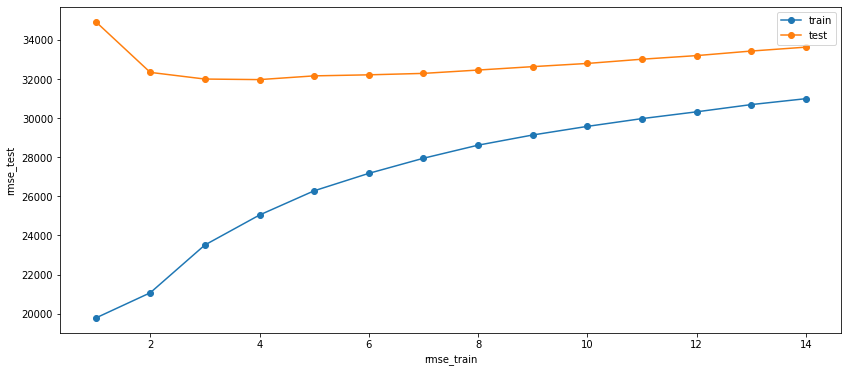

In [44]:
plt.figure(figsize = (14,6))
plt.plot(k_vecinos,lista_rmse_train,'o-',label='train' )
plt.plot(k_vecinos,lista_rmse_test,'o-',label='test')
plt.legend()
plt.xlabel('rmse_train')
plt.ylabel('rmse_test')

Optimiación para Arboles de desición

In [45]:
# Defino las listas vacias para los valores de mse deseados
lista_rmse_train = []
lista_rmse_test = []

# Defino la lista de valores de max_depth que voy a explorar
max_depths = np.arange(1,30)

# Genero en loop sobre los distintos valores de profundidad 
for max_depth in max_depths:
      
    # Definir el modelo con el valor de profundidad
    tree = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Entrenar el modelo
    tree.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = tree.predict(X_train)
    train_mse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = tree.predict(X_test)
    test_mse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Agregar la información a las listas
    lista_rmse_train.append(train_mse)
    lista_rmse_test.append(test_mse)

Text(0, 0.5, 'Exactitud')

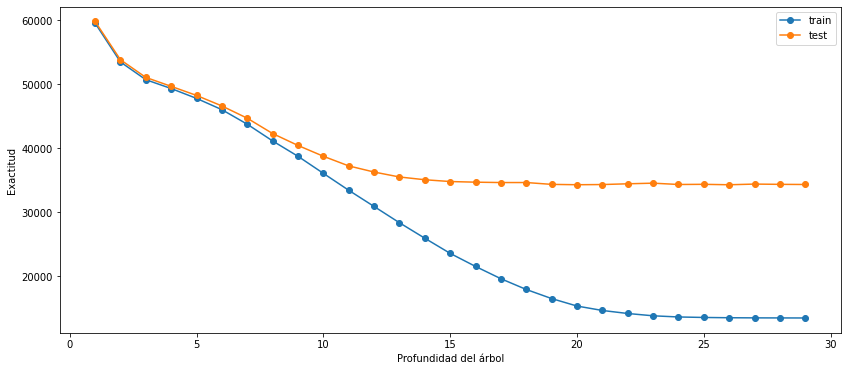

In [46]:
plt.figure(figsize = (14,6))
plt.plot(max_depths,lista_rmse_train,'o-',label='train' )
plt.plot(max_depths,lista_rmse_test,'o-',label='test')
plt.legend()
plt.xlabel('Profundidad del árbol')
plt.ylabel('Exactitud')

*Corro los modelos con los valores elegidos luego de la optimización*

In [47]:
tree_regressor = DecisionTreeRegressor(max_depth=11, random_state=42)
knn_regressor = KNeighborsRegressor(n_neighbors=10)

tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

Modelo: Árbol de Decisión
rmse en Train: 33431.30769604762
rmse en Test: 37235.946630570776


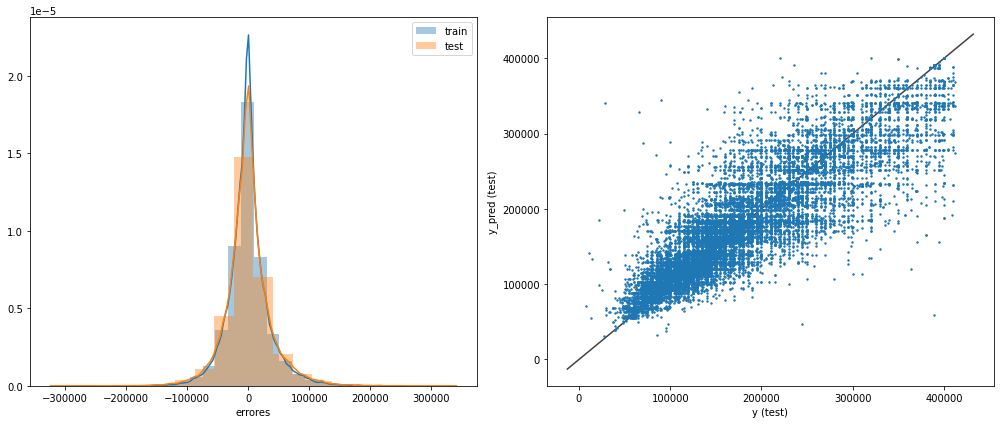

Modelo: Vecinos más cercanos
rmse en Train: 29579.1083285873
rmse en Test: 32799.82017290752


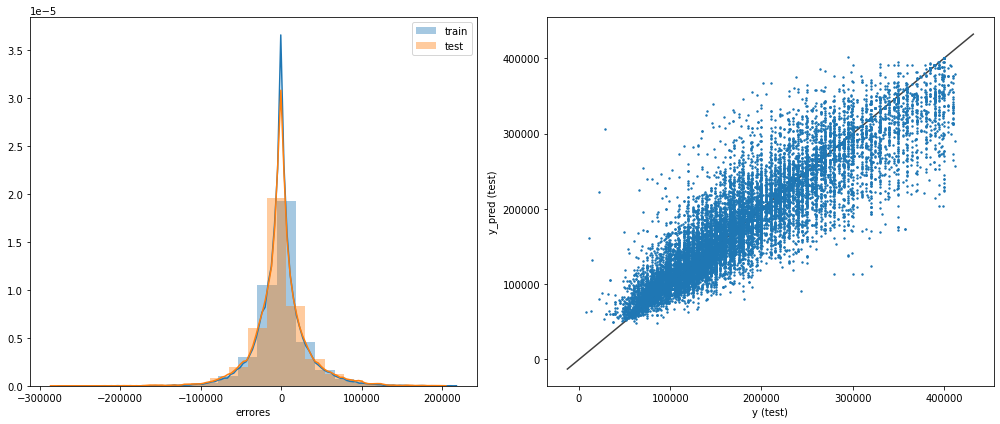

In [48]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'rmse en Train: {rmse_train}')
    print(f'rmse en Test: {rmse_test}')
    
    plt.figure(figsize = (14,6))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

*Veo cuales fueron las variables mas importantes para el modelo de árboles*

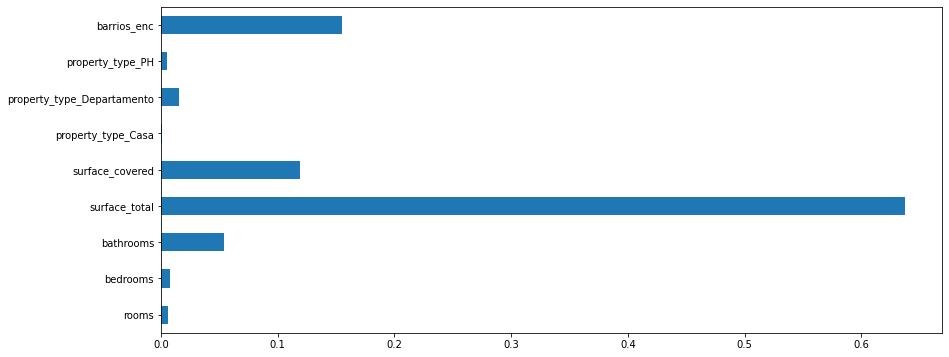

In [49]:
tree_regressor.feature_importances_
feature_inportence=pd.Series(tree_regressor.feature_importances_,index=X_train.columns)
plt.figure(figsize = (14,6))
feature_inportence.plot(kind='barh')

**Conclusión:**

Se nota una mejora considerable en el desempeño de los modelos con respecto a los del Proyecto 1, considero que se debe a la transformación de datos aplicada en cada uno de los puntos de este apartado, también vale destacar que la varible barrios_enc que surge de la transformación de la varible categórica l2, es la segunda variable mas importante en el modelo de árboles de desición.

## PARTE B - Modelos Avanzados

**Modelo: Regresión lineal con atributos polinómicos y regularización**

*Repito el proceso del punto A para separar los datos y y hacer un train test/test split de los datos*

In [50]:
#Volvemos separar los datos tal como hicimos en el punto A
X = data_modelos.drop("price", axis=1)
y = data_modelos.price
X.shape

(65681, 9)

In [51]:
# hacemos un Train/Test split de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45976, 9) (45976,) (19705, 9) (19705,)


*Creo un objeto a partir de PolynomialFeatures*

In [52]:
# debido a que el dataset ya posee un nro considerable de variables utilizo grado 3
poly = PolynomialFeatures(3,include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape, X_test_new.shape)

(45976, 219) (19705, 219)


*Aplico regularización entrenando un modelo Ridge*

*En este caso como parámetro para GridSearchCV tomamos distintos valores de Alpha*

In [53]:
model = Ridge()

In [54]:
params = {'alpha': [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]}

In [55]:
grid_ridge= GridSearchCV(model, params, cv=5)
grid_ridge.fit(X_train_new,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
#Predecimos sobre train y test
y_train_ridge = grid_ridge.predict(X_train_new)
y_test_ridge = grid_ridge.predict(X_test_new)

In [57]:
#Calculamos el error en train y test
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_ridge))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_ridge))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 45706.509999319635
Raíz del error cuadrático medio en Test: 50681.61150614115


*Mejores parametros modelo Ridge*

In [58]:
print("Mejores parametros: "+str(grid_ridge.best_params_))
print("Mejor Score: "+str(grid_ridge.best_score_)+'\n')

scores = pd.DataFrame(grid_ridge.cv_results_)
scores

Mejores parametros: {'alpha': 1}
Mejor Score: 0.6526331149048592



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.204583,0.032444,0.007795,0.005982,1,{'alpha': 1},0.661331,0.661000,0.653424,0.630946,0.656465,0.652633,0.011237,1
1,0.182669,0.006082,0.004725,0.000229,0.5,{'alpha': 0.5},0.661327,0.660989,0.653426,0.630958,0.656462,0.652632,0.011230,2
2,0.178050,0.006517,0.004423,0.000074,0.2,{'alpha': 0.2},0.661320,0.660979,0.653427,0.630966,0.656460,0.652631,0.011224,3
3,0.176156,0.004587,0.004483,0.000182,0.1,{'alpha': 0.1},0.661317,0.660975,0.653428,0.630969,0.656459,0.652630,0.011221,4
4,0.177172,0.004634,0.004635,0.000159,0.05,{'alpha': 0.05},0.661315,0.660973,0.653428,0.630971,0.656458,0.652629,0.011220,5
5,0.185877,0.009163,0.004743,0.000300,0.02,{'alpha': 0.02},0.661314,0.660972,0.653428,0.630972,0.656458,0.652629,0.011219,6
6,0.177184,0.004918,0.004628,0.000217,0.01,{'alpha': 0.01},0.661313,0.660971,0.653428,0.630972,0.656458,0.652629,0.011219,7


*Aplico regularización entrenando un modelo Lasso*

*En este caso como parámetro para GridSearchCV tomamos distintos valores de Alpha*

In [59]:
model = Lasso()

In [60]:
params = {'alpha': [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]}

In [61]:
grid_lasso= GridSearchCV(model, params, cv=5)
grid_lasso.fit(X_train_new,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [62]:
#Predecimos sobre train y test
y_train_lasso = grid_lasso.predict(X_train_new)
y_test_lasso = grid_lasso.predict(X_test_new)

In [63]:
#Calculamos el error en train y test
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_lasso))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_lasso))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 45715.57149309438
Raíz del error cuadrático medio en Test: 47093.850145799486


*Mejores parámetros modelo Lasso*

In [64]:
print("Mejores parametros: "+str(grid_lasso.best_params_))
print("Mejor Score: "+str(grid_lasso.best_score_)+'\n')

scores = pd.DataFrame(grid_lasso.cv_results_)
scores

Mejores parametros: {'alpha': 1}
Mejor Score: 0.6528347058401078



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.847866,0.073445,0.004608,0.000186,1,{'alpha': 1},0.661323,0.661433,0.653528,0.631046,0.656843,0.652835,0.011290,1
1,10.139846,0.112532,0.004974,0.000362,0.5,{'alpha': 0.5},0.661320,0.661374,0.653574,0.631023,0.656847,0.652828,0.011290,2
2,10.540363,0.213664,0.005161,0.000415,0.2,{'alpha': 0.2},0.661324,0.661333,0.653563,0.630997,0.656839,0.652811,0.011294,3
3,10.597385,0.217792,0.005131,0.000249,0.1,{'alpha': 0.1},0.661322,0.661328,0.653557,0.630992,0.656834,0.652807,0.011294,4
4,10.359929,0.253262,0.004867,0.000190,0.05,{'alpha': 0.05},0.661321,0.661325,0.653553,0.630989,0.656834,0.652804,0.011295,5
5,10.275481,0.106125,0.004795,0.000077,0.02,{'alpha': 0.02},0.661321,0.661324,0.653551,0.630986,0.656832,0.652803,0.011295,6
6,10.392154,0.183030,0.004725,0.000129,0.01,{'alpha': 0.01},0.661321,0.661324,0.653550,0.630985,0.656832,0.652802,0.011296,7


**Modelo: Randon Forest**

In [65]:
X = data_modelos.drop("price", axis=1)
y = data_modelos.price
X.shape

(65681, 9)

In [66]:
# hacemos un Train/Test split de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45976, 9) (45976,) (19705, 9) (19705,)


In [67]:
clf = RandomForestClassifier(n_estimators=10,max_features='sqrt',max_depth=25,bootstrap= True, n_jobs=-1)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [68]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [69]:
#Calculamos el error en train y test
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 18473.805332859843
Raíz del error cuadrático medio en Test: 39054.795239701634


*Variables mas importantes modelo Random Forest*

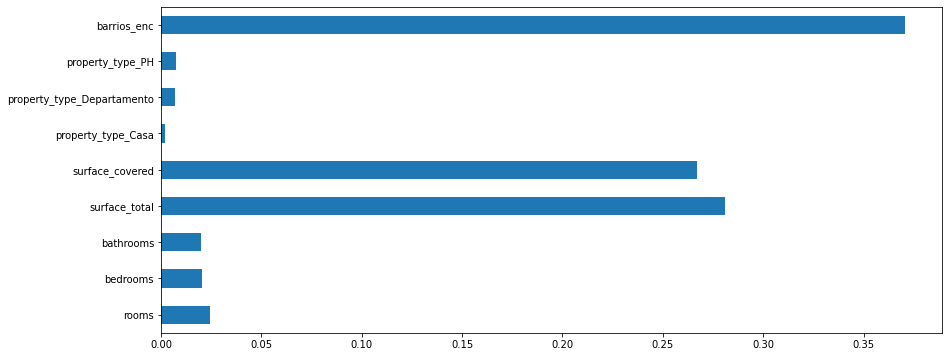

In [70]:
clf.feature_importances_
feature_inportence=pd.Series(clf.feature_importances_,index=X_train.columns)
plt.figure(figsize = (14,6))
feature_inportence.plot(kind='barh')

**Comparación de modelos**

Comparando los modelos del punto b entre sí considero que Ridge y Lasso no están funcionando de acuerdo a lo esperado, por lo que pude investigar Ridge funciona mejor cuando la mayoría de los atributos son relevantes (no es el caso de este dataset), y Lasso cuando los atributos están muy correlacionados entre sí, en este caso hay correlación fuerte entre algunos atributos, pero el desempeño no es el esperado, Random Forest tiene buen desempeño en train pero no así en test, considero que es debido a que lo corrí solamente con 10 arboles debido a la limitación de memoria de mi máquina, lo mismo me pasó con colab, ni tampoco pude optimizar los parámetros con Grid o random Search, seguramente con más árboles podría llegar a una mejor estimación.

Y por último comparado con los modelos del punto A seguramente elegiría Random Forest y llegaría a un mejor desempeño pero para ello debo contar con los recursos necesarios para ejecutarlo. 

## PARTE C - Interpretación de Modelos

Toamando como ejemplo el modelo Random Forest, podemos decir que como feature mas importante tomo a los barrios, luego la superficie total y la superfice cubierta, en el primer punto el modelo de árbol de desición prevaleció la superficie cubierta por sobre el resto de las variables. Un dato no menor es que en Random Forest si bien el rmse_train es bueno comparado con los otros modelos, hay mucha diferencia con el rmse en test, por lo que sería necesario correrlo con mas árboles, tal como expresé en el punto anterior usé solo 10 por la limitación de memoria, tanto en mi máquina como en colab, por lo cual me parece que con mas árboles se podría optimizar el rsme y obtener una mejor estimación. En este punto esperaba poder correr sin problemas Random Forest y que el error en test sea parecido al de train, a fin de asegurar que el modelo es el óptimo.

A continuación muestro el peso de cada variable en los 10 árboles generados en Random Forest, en general no hay mucha diferencia en los árboles ya que en todos la variable mas importante son los barrios, solo en algunos cambia la superficie total por la superficie cubierta.

In [71]:
lista_arboles=np.arange(0,9)

for i in lista_arboles:
    print(f'Features mas importantes arbol: {i}')
    feature_inportence=pd.Series(clf[i].feature_importances_,index=X_train.columns)
    print(feature_inportence)

Features mas importantes arbol: 0
rooms                         0.026363
bedrooms                      0.018178
bathrooms                     0.031982
surface_total                 0.271433
surface_covered               0.259031
property_type_Casa            0.001712
property_type_Departamento    0.006278
property_type_PH              0.005286
barrios_enc                   0.379738
dtype: float64
Features mas importantes arbol: 1
rooms                         0.011312
bedrooms                      0.014693
bathrooms                     0.015095
surface_total                 0.283992
surface_covered               0.288215
property_type_Casa            0.000741
property_type_Departamento    0.001035
property_type_PH              0.000269
barrios_enc                   0.384647
dtype: float64
Features mas importantes arbol: 2
rooms                         0.022831
bedrooms                      0.022624
bathrooms                     0.032971
surface_total                 0.279301
surface_co

En cuanto a la distribución de los errores es muy grande en train y test, esto se debe a que como comenté anteriormente no pude optimizar al modelo agregando mas árboles para estimar

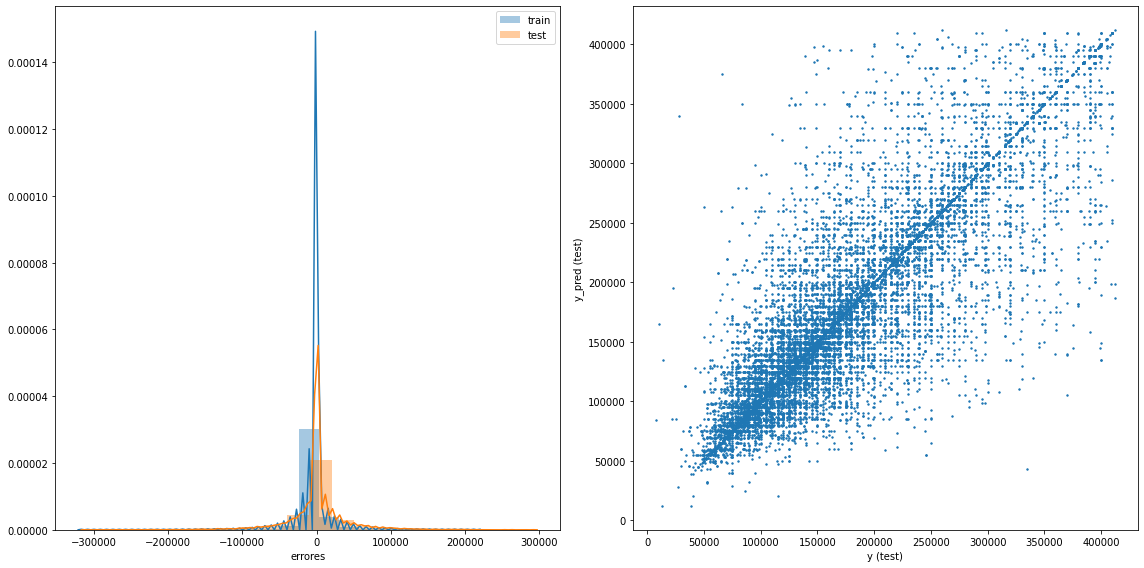

In [72]:
plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

Por último evaluando los resultados de los diferentes modelos considero que los implementados en en punto B no son lo esperado, con el fin de simplificar el dataset para compararlo con los del Proyecto 1 y que se pueda correr con menos recursos, se eliminaron algunas columnas que podrían ser de utilidad como ser latutud y longitud, ya que por la amplitud de algunos barrios el precio de las propiedades puede variar considerablemente, además se filtro solo por tres tipos de propiedades y para Capital Federal, de esta manera se armó un conjunto de datos reducido excluyendo información que podría haber haber ayudado a los modelos a predecir mejor.

Otro punto donde se podría considerar que se podría mejorar y por ende pudo ser una falla, es en el momento de aplicar la tranformación a la varible l3 usando Label Encoder, en este punto si bien aclaré que l3 no es una variable ordinal, usé ese método ya que usando OneHotEncoder generaría gran cantidad de variables, de hecho lo había probado en el punto A y no generaba mejores resultados, esto se hizo con el fin de no agregar complejidad, pero no se probó luego en el punto B.

De acuerdo a lo mencionado en los párrafos anteriores, considero que si hubiera usado el dataset completo, no descartar las columnas latitud y longitud y aplicando OneHotEncoder a l3, hubiera obtenido un dataset con muchas columnas, pero si no obtubiese buenos resultados se podría aplicar reducción de dimensionalidad y probar nuevamente su desempeño.

Otro tema sobre el cual ya hice mención y considero puede mejorar pero no lo hice por falta de recursos, es correr Random Forest con mas árboels y sin limitarles la profundidad por ejemplo, de manera que el modelo me diga en que punto encuentra el rendiminto óptimo, nombro Random porque es el que elegí pero sin dudas que también hubiese sido bueno correr otra técnica de ensamble como ser un XGBoost y compararlo con Forest.

## Desafío opcional

En esta sección voy a usar Singular Value Decomposition (SVD) para aplicar reducción de dimensionalidad así luego poder aplicar una técnica de Clustering, si bien SVD corresponde a la parte A de transformación de datos lo hago en este apartado para que quede todo junto dentro del desafío opcional

*Uso el dataset al cual se le aplicó el escalado de datos*

In [73]:
data_svd=data_scaler.copy()
data_svd.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
1,Capital Federal,Boedo,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,PH
2,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,PH
3,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,PH
5,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,-0.416126,-0.178409,150000.0,PH
6,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,0.041585,0.395819,159500.0,PH


*Aplico la reducción*

In [74]:
SVD=TruncatedSVD(n_components=1, random_state=42)
data_svd['cant_hab']=SVD.fit_transform(data_svd[['rooms','bathrooms','bedrooms']])
data_svd['superficie']=SVD.fit_transform(data_svd[['surface_total','surface_covered']])

In [75]:
data_svd.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,cant_hab,superficie
1,Capital Federal,Boedo,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,PH,-0.440944,-0.038743
2,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,PH,-1.263032,-0.993728
3,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,PH,-1.263032,0.076002
5,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,-0.416126,-0.178409,150000.0,PH,-1.263032,-0.420400
6,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,0.041585,0.395819,159500.0,PH,-1.263032,0.309291


*Copio el dataset y separo los datos sobre los que se aplicará K means*

In [76]:
data_cluster=data_svd.copy()
X = np.array(data_cluster[["cant_hab","superficie"]])
X.shape

(65681, 2)

*Gráfica elbow o de codo para determinar el número óptimo de clústeres*

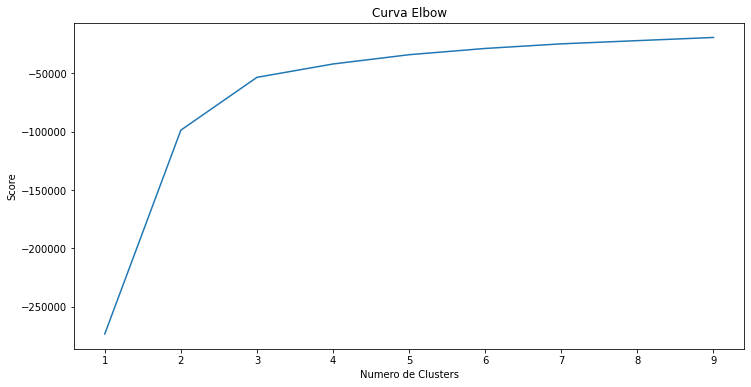

In [77]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

plt.figure(figsize=(12,6))
plt.plot(Nc,score)
plt.xlabel('Numero de Clusters')
plt.ylabel('Score')
plt.title('Curva Elbow')
plt.show()

*Aplico K means con K=3*

In [78]:
kmeans = KMeans(n_clusters=3).fit(X)
centros = kmeans.cluster_centers_
print(centros)

[[-1.39877652 -1.08031932]
 [ 0.53556261  0.19524001]
 [ 2.23423089  2.13699158]]


In [79]:
etiquetas=kmeans.labels_
print(etiquetas)

[1 0 0 ... 1 1 1]


*Etiqueto el dataset*

In [80]:
#asigno cada registro del dataset a uno de los clústers
labels = kmeans.predict(X)
data_cluster['label'] = labels

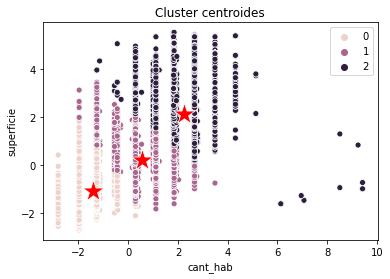

In [81]:
sns.scatterplot(data_cluster['cant_hab'], data_cluster['superficie'], hue = etiquetas )
sns.scatterplot(centros[:, 0], centros[:, 1],color='red', marker="*", s=500)
plt.title('Cluster centroides')
plt.show()

*Compruebo cuantos registros hay en cada cluster*

In [82]:
data_cluster.groupby('label').size()

label
0    29273
1    23789
2    12619
dtype: int64

In [83]:
data_cluster.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,cant_hab,superficie,label
1,Capital Federal,Boedo,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,PH,-0.440944,-0.038743,1
2,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,PH,-1.263032,-0.993728,0
3,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,PH,-1.263032,0.076002,0
5,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,-0.416126,-0.178409,150000.0,PH,-1.263032,-0.420400,0
6,Capital Federal,Villa Crespo,-0.689694,-0.925024,-0.540584,0.041585,0.395819,159500.0,PH,-1.263032,0.309291,0


*Reemplazo en valor de cada cluster por un nombre para luego poder visualizarlo*

In [84]:
data_cluster['label']=data_cluster['label'].replace(0,'Cluster0')
data_cluster['label']=data_cluster['label'].replace(1,'Cluster1')
data_cluster['label']=data_cluster['label'].replace(2,'Cluster2')

In [85]:
data_cluster.head(3)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,cant_hab,superficie,label
1,Capital Federal,Boedo,-0.689694,-0.925024,1.270582,0.041585,-0.096376,159000.0,PH,-0.440944,-0.038743,Cluster1
2,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,-0.775756,-0.629588,125000.0,PH,-1.263032,-0.993728,Cluster0
3,Capital Federal,Palermo,-0.689694,-0.925024,-0.540584,0.531989,-0.424506,295000.0,PH,-1.263032,0.076002,Cluster0


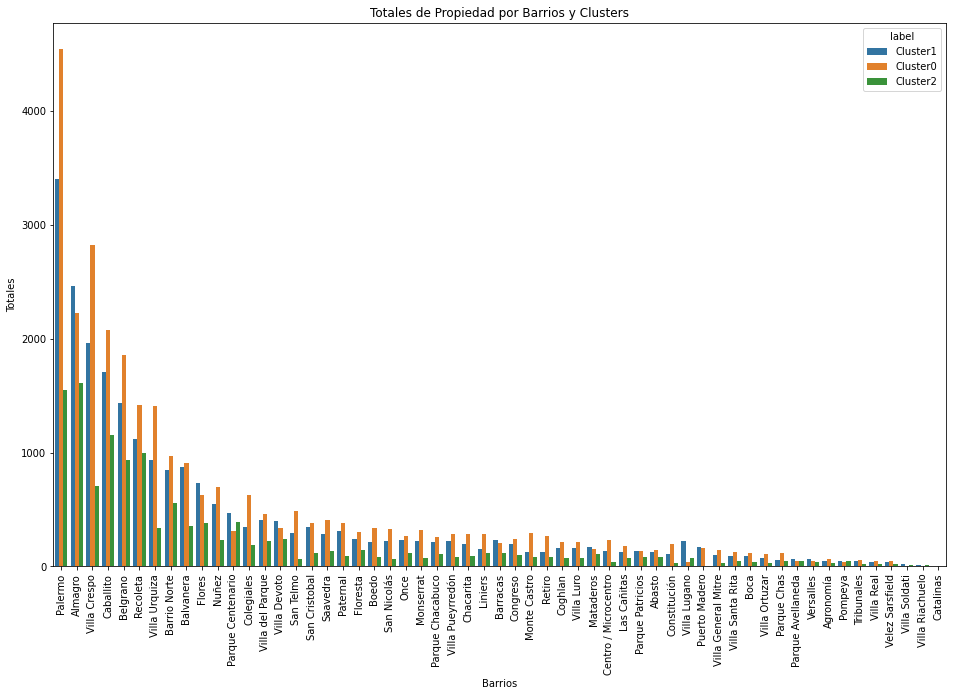

In [86]:
plt.figure(figsize = (16,10))
plt.subplot(1,1,1)
ax2=sns.countplot(x="l3",hue="label",data=data_cluster,order=data_cluster['l3'].value_counts().index)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="center")
plt.title('Totales de Propiedad por Barrios y Clusters')
plt.xlabel('Barrios')
plt.ylabel('Totales')

plt.show()

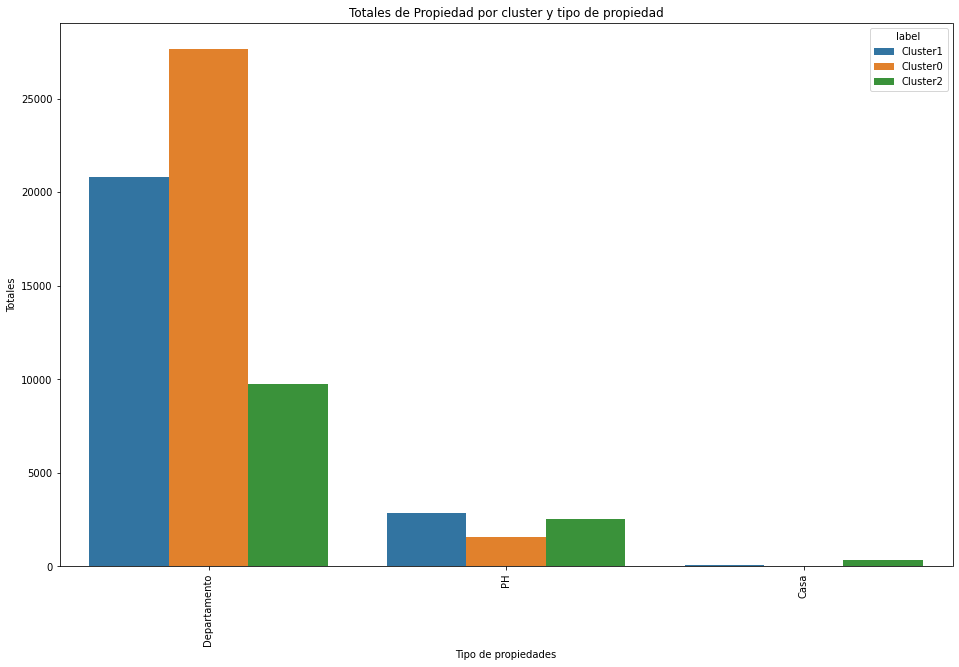

In [87]:
plt.figure(figsize = (16,10))
plt.subplot(1,1,1)
ax2=sns.countplot(x="property_type",hue="label",data=data_cluster,order=data_cluster['property_type'].value_counts().index)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="center")
plt.title('Totales de Propiedad por cluster y tipo de propiedad')
plt.xlabel('Tipo de propiedades')
plt.ylabel('Totales')

plt.show()

**Conclusiones**

Desde mi punto de vista por lo observado en el gráfico de distribución de propiedades según clusters, las casas y los PH se parecen mas entre si porque predominan mas propiedades de los clusters 1 y 2, que son las que superficies y habitaciones, no así en los departamentos donde predominan propiedades del cluster 0 que son las de poca superficie y menor cantidad de habitaciones.

En cuanto a los barrios la mayoría tiene un comportamiento similiar predominado las propiedades del cluster 0, ya que la mayoría de las propiedades del dataset son departamentos, Almagro dentro de los barrios con mas propiedade tiene mayoría de propiedades del cluster 2 sobre el 1.